In [18]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import pingouin as pg
import warnings
warnings.filterwarnings('ignore')

Dataset for coverage: 
https://immunizationdata.who.int/global/wiise-detail-page/human-papillomavirus-%28hpv%29-vaccination-coverage?GROUP=Countries&ANTIGEN=PRHPVC_F&YEAR=&CODE=

In [19]:
# Load data from coverage_2024 sheet from dl_project_section_1.xlsx

df = pd.read_excel(
    '../dat/Socio_Econ/02_cleaned_data/dl_project_section_1.xlsx',
    sheet_name="coverage_2024",
    engine="openpyxl",
)
df

,country_code,vax_year,country_name,HPV_PRIM_DELIV_STRATEGY,HPV_INT_DOSES,Gavi Status,HPV_NATIONAL_SCHEDULE,FIRST_DOSE_COV,LAST_DOSE_COV,income_class
0,ALB,2024,Albania,Facility-based,1 dose,Non-Gavi,Yes,43.0,43.0,UM
1,AND,2024,Andorra,School-based,2 doses (6 months),Non-Gavi,Yes,92.0,82.0,H
2,ATG,2024,Antigua and Barbuda,Facility-based,2 doses (6 months),Non-Gavi,Yes,2.0,1.0,H
3,ARG,2024,Argentina,Varies by region/province,1 dose,Non-Gavi,Yes,55.0,55.0,UM
4,ARM,2024,Armenia,Facility-based,1 dose,Non-Gavi,Yes,38.0,31.0,UM
...,...,...,...,...,...,...,...,...,...,...
147,URY,2024,Uruguay,Facility-based,2 doses (6 months),Non-Gavi,Yes,77.0,54.0,H
148,UZB,2024,Uzbekistan,School-based,1 dose,Non-Gavi,Yes,91.0,99.0,LM
149,VUT,2024,Vanuatu,School-based,1 dose,Non-Gavi,Yes,43.0,43.0,LM
150,ZMB,2024,Zambia,School-based,1 dose,Gavi,Yes,60.0,60.0,LM


In [20]:
req = ["HPV_PRIM_DELIV_STRATEGY", "HPV_INT_DOSES", "Gavi Status",
       "FIRST_DOSE_COV", "LAST_DOSE_COV", "income_class"]

df2 = df.dropna(subset=req).copy()  

def income_dist_by_gavi(label):
    sub = df2[df2["Gavi Status"] == label]
    if len(sub) == 0:
        print(f"No {label} countries found\n")
        return
    
    dist = sub["income_class"].value_counts().sort_index()
    print(f"{label} countries by income level:")
    
    for income, count in dist.items():
        pct = count / len(sub) * 100
        print(f"  {income}: {count} countries ({pct:.1f}%)")
    
    print(f"\nTotal {label} countries: {len(sub)}\n")

for status in ["Gavi", "Non-Gavi"]:
    income_dist_by_gavi(status)

Gavi countries by income level:
  L: 10 countries (43.5%)
  LM: 13 countries (56.5%)

Total Gavi countries: 23

Non-Gavi countries by income level:
  H: 52 countries (53.1%)
  LM: 10 countries (10.2%)
  UM: 36 countries (36.7%)

Total Non-Gavi countries: 98



## Core Question: Does Gavi allow countries to catch up to high-income countries in vaccination coverage?

In [21]:
# Income level vs Gavi status (imbalance check)
pd.crosstab(df['income_class'], df['Gavi Status'], margins=True)

Gavi Status,Gavi,Non-Gavi,All
income_class,,,
H,0,62,62
L,12,0,12
LM,18,12,30
UM,0,46,46
All,30,120,150


In [22]:
# !!! FIRST DOSE COVERAGE is used in here !!!
# 1. T-test, Gavi vs High-Income countries on vaccination coverage
gavi = df.loc[df['Gavi Status'] == 'Gavi', 'FIRST_DOSE_COV'].dropna()
high_income = df.loc[df['income_class'] == 'H', 'FIRST_DOSE_COV'].dropna()

t_stat, p_val = stats.ttest_ind(gavi, high_income)
print(f'T-test: Gavi vs High-Income')
print(f'Gavi mean: {gavi.mean():.2f} (n={len(gavi)}), High-Income mean: {high_income.mean():.2f} (n={len(high_income)})')
print(f't-statistic: {t_stat:.3f}, p-value: {p_val:.4f}')

# 2. T-test within Gavi countries (L & LM) vs Middle Income (LM & UM) non-gavi countries
m_non_gavi = df.loc[(df['income_class'].isin(['LM', 'UM'])) & (df['Gavi Status'] == 'Non-Gavi'), 
                     'FIRST_DOSE_COV'].dropna()

t_stat, p_val = stats.ttest_ind(gavi, m_non_gavi)
print(f'\nT-test: Gavi countries (L & LM) vs Middle Income (LM & UM) non-gavi countries')
print(f'Gavi mean: {gavi.mean():.2f} (n={len(gavi)})')
print(f'M-Non-Gavi mean: {m_non_gavi.mean():.2f} (n={len(m_non_gavi)})')
print(f't-statistic: {t_stat:.3f}, p-value: {p_val:.4f}')

# 3. Gavi countries (L & LM) vs Low-Middle Income non-gavi countries
lm_non_gavi = df.loc[(df['income_class'] == 'LM') & (df['Gavi Status'] == 'Non-Gavi'), 
                     'FIRST_DOSE_COV'].dropna()
t_stat, p_val = stats.ttest_ind(gavi, lm_non_gavi)
print(f'\nT-test: ')
print(f'Gavi mean: {gavi.mean():.2f} (n={len(gavi)})')
print(f'M-Non-Gavi mean: {lm_non_gavi.mean():.2f} (n={len(lm_non_gavi)})')
print(f't-statistic: {t_stat:.3f}, p-value: {p_val:.4f}')


T-test: Gavi vs High-Income
Gavi mean: 68.59 (n=29), High-Income mean: 62.85 (n=59)
t-statistic: 1.041, p-value: 0.3009

T-test: Gavi countries (L & LM) vs Middle Income (LM & UM) non-gavi countries
Gavi mean: 68.59 (n=29)
M-Non-Gavi mean: 58.30 (n=54)
t-statistic: 1.665, p-value: 0.0997

T-test: 
Gavi mean: 68.59 (n=29)
M-Non-Gavi mean: 62.42 (n=12)
t-statistic: 0.743, p-value: 0.4622


In [23]:
# Drop-off analysis
# filter for countries with both doses recorded
df2_complete = df2[(df2['FIRST_DOSE_COV'].notna()) & (df2['LAST_DOSE_COV'].notna())].copy()
df2_complete['dropoff'] = df2_complete['FIRST_DOSE_COV'] - df2_complete['LAST_DOSE_COV']

# Get Gavi and High-Income dropoff values
gavi_dropoff = df2_complete[df2_complete['Gavi Status'] == 'Gavi']['dropoff']
hi_dropoff = df2_complete[df2_complete['income_class'] == 'H']['dropoff']

print(f'Drop-off comparison')
print(f'Gavi countries with complete data: {len(gavi_dropoff)}')
print(f'High-Income countries with complete data: {len(hi_dropoff)}')

if len(gavi_dropoff) > 1 and len(hi_dropoff) > 1:
    print(f'Gavi mean: {gavi_dropoff.mean():.2f}, High-Income mean: {hi_dropoff.mean():.2f}')
    print(f'Gavi median: {gavi_dropoff.median():.2f}, High-Income median: {hi_dropoff.median():.2f}')
    
    t_stat_drop, p_val_drop = stats.ttest_ind(gavi_dropoff, hi_dropoff)
    print(f't-statistic: {t_stat_drop:.3f}, p-value: {p_val_drop:.4f}')
else:
    print(f'Gavi mean: {gavi_dropoff.mean():.2f}, High-Income mean: {hi_dropoff.mean():.2f}')
    print('Insufficient data for statistical test (need at least 2 observations per group)')

Drop-off comparison
Gavi countries with complete data: 23
High-Income countries with complete data: 52
Gavi mean: 5.57, High-Income mean: 6.62
Gavi median: 0.00, High-Income median: 4.00
t-statistic: -0.399, p-value: 0.6911


# Mediation Analysis: Gavi Status, Delivery/Dosing, and HPV Coverage

Does Gavi funding status affect HPV vaccine coverage through delivery strategy or dosing schedule?

| Variable | Role | Type | Values |
|----------|------|------|---------|
| Gavi Status | Independent (X) | Binary | 0=Non-Gavi, 1=Gavi |
| Delivery Strategy | Mediator (M1) | Categorical | School-based, Facility-based, Mixed, Varies |
| Dosing Schedule | Mediator (M2) | Categorical | 1 dose, 2 doses (6mo), 2 doses (12mo) |
| HPV1 Coverage | Dependent (Y) | Continuous | 0-1 |

## Analysis Structure

### Part 1: Traditional Tests 
- **Path A**: Chi-square test (X → M association)
- **Path B**: One-way ANOVA (M → Y differences)
- **Path C**: Independent t-test (X → Y total effect)

### Part 2: Regression-Based Mediation (Pingouin)
- **Path a**: Linear regression (X → M)
- **Path b**: Linear regression (M → Y | X)
- **Path c'**: Direct effect (X → Y | M)
- **Indirect effect**: Bootstrap CI for a × b

### Part 3: Visualization

In [26]:

# Filter complete cases
df_analysis = df[
    df['FIRST_DOSE_COV'].notna() &
    df['HPV_PRIM_DELIV_STRATEGY'].notna() &
    df['HPV_INT_DOSES'].notna() &
    df['Gavi Status'].notna()
].copy()

# Encode variables
df_analysis['X'] = (df_analysis['Gavi Status'] == 'Gavi').astype(int)
df_analysis['Y'] = df_analysis['FIRST_DOSE_COV']

# Numeric encoding for mediators
delivery_map = {'School-based': 0, 'Facility-based': 1, 'mixed': 2, 'Varies by region/province': 3}
dose_map = {'1 dose': 1, '2 doses (6 months)': 2, '2 doses (12 months)': 3}
df_analysis['M1'] = df_analysis['HPV_PRIM_DELIV_STRATEGY'].map(delivery_map)
df_analysis['M2'] = df_analysis['HPV_INT_DOSES'].map(dose_map)

print(f"N = {len(df_analysis)} countries with complete data")
print(f"Gavi: {df_analysis['X'].sum()}, Non-Gavi: {(df_analysis['X']==0).sum()}")

N = 126 countries with complete data
Gavi: 23, Non-Gavi: 103


## PART1: Traditional Statistical Tests

In [27]:
def calculate_model_stats(df, mediator_var):
    """
    Calculate all statistics for a mediation model
    Returns a dictionary with all statistics needed for plotting
    """
    results = {}
    
    # PATH A: Chi-square test (Gavi Status → Mediator)
    contingency = pd.crosstab(df['X'], df[mediator_var])
    chi2, p_a, dof, expected = stats.chi2_contingency(contingency)
    results['a_stat'] = chi2
    results['a_p'] = p_a
    
    # PATH B: ANOVA (Mediator → Coverage)
    mediator_values = df[mediator_var].dropna().unique()
    groups = [df[df[mediator_var]==val]['Y'].values for val in mediator_values]
    f_stat, p_b = stats.f_oneway(*groups)
    results['b_stat'] = f_stat
    results['b_p'] = p_b
    
    # PATH C: t-test (Gavi Status → Coverage)
    gavi = df[df['X']==1]['Y']
    non_gavi = df[df['X']==0]['Y']
    t_stat, p_c = stats.ttest_ind(gavi, non_gavi)
    results['t_stat'] = t_stat
    results['c_p'] = p_c
    
    # Sample sizes
    results['n_gavi'] = len(gavi)
    results['n_non_gavi'] = len(non_gavi)
    results['n_total'] = len(df)
    
    # Additional descriptive statistics
    results['gavi_mean'] = gavi.mean()
    results['non_gavi_mean'] = non_gavi.mean()
    results['mean_diff'] = gavi.mean() - non_gavi.mean()
    
    # Means by mediator categories
    mediator_means = df.groupby(mediator_var)['Y'].agg(['mean', 'count', 'std']).round(3)
    results['mediator_means'] = mediator_means
    
    return results

def draw_mediation(ax, mediator, stats_dict):
    """
    Draw mediation diagram using statistics from dictionary
    """
    ax.set_xlim(0, 10)
    ax.set_ylim(0, 8)
    ax.axis('off')
    
    # Node positions
    X, M, Y = (1.5, 3), (5, 6.5), (8.5, 3)
    
    # Draw nodes
    for pos, label, color in [(X, 'Gavi Status', '#E8F4FD'), 
                              (M, mediator, '#FFF9E6'), 
                              (Y, 'HPV Coverage', '#E8F8E8')]:
        ax.add_patch(plt.Rectangle((pos[0]-1.2, pos[1]-0.6), 2.4, 1.2, 
                     facecolor=color, edgecolor='#333', linewidth=1.5, zorder=2))
        ax.text(pos[0], pos[1], label, ha='center', va='center', 
                fontsize=11, fontweight='bold', zorder=3)
    
    # Formatting function
    def fmt(stat_val, p, stat_type='chi2'):
        color = '#2E7D32' if p < 0.05 else '#757575'
        weight = 'bold' if p < 0.05 else 'normal'
        lw = 2 if p < 0.05 else 1
        
        if stat_type == 'chi2':
            label = f'χ² = {stat_val:.2f}'
        elif stat_type == 'F':
            label = f'F = {stat_val:.2f}'
        else:  # t-test
            label = f't = {stat_val:.2f}'
        
        return label, color, weight, lw
    
    # Draw path a: X → M (Chi-square)
    a_txt, a_col, a_wt, a_lw = fmt(stats_dict['a_stat'], stats_dict['a_p'], 'chi2')
    ax.annotate('', xy=(M[0]-1, M[1]-0.6), xytext=(X[0]+0.8, X[1]+0.6),
                arrowprops=dict(arrowstyle='-|>', color=a_col, lw=a_lw))
    ax.text(3.0, 5.9, f'Path a\n{a_txt}\np = {stats_dict["a_p"]:.3f}', 
            fontsize=10, color=a_col, fontweight=a_wt, ha='center', va='center', 
            linespacing=1.3, bbox=dict(boxstyle='round,pad=0.3', 
            facecolor='white', edgecolor='none', alpha=0.8))
    
    # Draw path b: M → Y (ANOVA)
    b_txt, b_col, b_wt, b_lw = fmt(stats_dict['b_stat'], stats_dict['b_p'], 'F')
    ax.annotate('', xy=(Y[0]-0.8, Y[1]+0.6), xytext=(M[0]+1, M[1]-0.6),
                arrowprops=dict(arrowstyle='-|>', color=b_col, lw=b_lw))
    ax.text(7.0, 5.9, f'Path b\n{b_txt}\np = {stats_dict["b_p"]:.3f}', 
            fontsize=10, color=b_col, fontweight=b_wt, ha='center', va='center', 
            linespacing=1.3, bbox=dict(boxstyle='round,pad=0.3', 
            facecolor='white', edgecolor='none', alpha=0.8))
    
    # Draw path c': X → Y (t-test)
    c_txt, c_col, c_wt, c_lw = fmt(stats_dict['t_stat'], stats_dict['c_p'], 't')
    ax.annotate('', xy=(Y[0]-1.2, Y[1]), xytext=(X[0]+1.2, X[1]),
                arrowprops=dict(arrowstyle='-|>', color=c_col, lw=c_lw, linestyle='--'))
    ax.text(5, 2.2, f"Path c'\n{c_txt}\np = {stats_dict['c_p']:.3f}", 
            fontsize=10, color=c_col, fontweight=c_wt, ha='center', va='center', 
            linespacing=1.3, bbox=dict(boxstyle='round,pad=0.3', 
            facecolor='white', edgecolor='none', alpha=0.8))

MODEL STATISTICS SUMMARY

Model 1: Delivery Strategy
----------------------------------------
Path a (χ²): 7.9044, p = 0.0480
Path b (F): 2.0780, p = 0.1066
Path c (t): 0.6448, p = 0.5203
Gavi mean: 66.957, Non-Gavi mean: 63.155
Mean difference: 3.801

Means by Delivery Strategy:
                             mean  count     std
HPV_PRIM_DELIV_STRATEGY                         
Facility-based             53.893     28  28.359
School-based               67.679     78  23.824
Varies by region/province  60.500      2   7.778
mixed                      63.111     18  26.419


Model 2: Dosing Schedule
----------------------------------------
Path a (χ²): 20.1090, p = 0.0000
Path b (F): 0.0077, p = 0.9923
Path c (t): 0.6448, p = 0.5203
Gavi mean: 66.957, Non-Gavi mean: 63.155
Mean difference: 3.801

Means by Dosing Schedule:
                       mean  count     std
HPV_INT_DOSES                             
1 dose               64.061     66  26.309
2 doses (12 months)  65.000      2  21.213

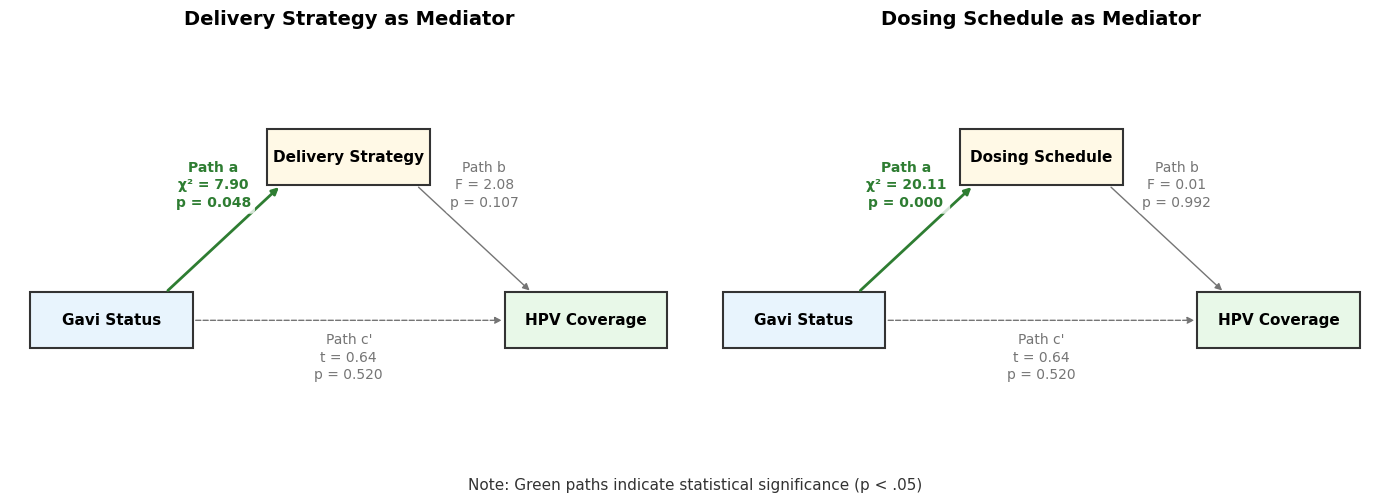

In [28]:
# Main execution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Calculate statistics for both models
delivery_stats = calculate_model_stats(df_analysis, 'HPV_PRIM_DELIV_STRATEGY')
dosing_stats = calculate_model_stats(df_analysis, 'HPV_INT_DOSES')

# Print summary of statistics
print("="*70)
print("MODEL STATISTICS SUMMARY")
print("="*70)

print("\nModel 1: Delivery Strategy")
print("-"*40)
print(f"Path a (χ²): {delivery_stats['a_stat']:.4f}, p = {delivery_stats['a_p']:.4f}")
print(f"Path b (F): {delivery_stats['b_stat']:.4f}, p = {delivery_stats['b_p']:.4f}")
print(f"Path c (t): {delivery_stats['t_stat']:.4f}, p = {delivery_stats['c_p']:.4f}")
print(f"Gavi mean: {delivery_stats['gavi_mean']:.3f}, Non-Gavi mean: {delivery_stats['non_gavi_mean']:.3f}")
print(f"Mean difference: {delivery_stats['mean_diff']:.3f}")
print("\nMeans by Delivery Strategy:")
print(delivery_stats['mediator_means'])

print("\n" + "="*70)
print("\nModel 2: Dosing Schedule")
print("-"*40)
print(f"Path a (χ²): {dosing_stats['a_stat']:.4f}, p = {dosing_stats['a_p']:.4f}")
print(f"Path b (F): {dosing_stats['b_stat']:.4f}, p = {dosing_stats['b_p']:.4f}")
print(f"Path c (t): {dosing_stats['t_stat']:.4f}, p = {dosing_stats['c_p']:.4f}")
print(f"Gavi mean: {dosing_stats['gavi_mean']:.3f}, Non-Gavi mean: {dosing_stats['non_gavi_mean']:.3f}")
print(f"Mean difference: {dosing_stats['mean_diff']:.3f}")
print("\nMeans by Dosing Schedule:")
print(dosing_stats['mediator_means'])

# Draw the plots
draw_mediation(axes[0], 'Delivery Strategy', delivery_stats)
axes[0].set_title('Delivery Strategy as Mediator', fontsize=14, fontweight='bold', pad=45)

draw_mediation(axes[1], 'Dosing Schedule', dosing_stats)
axes[1].set_title('Dosing Schedule as Mediator', fontsize=14, fontweight='bold', pad=45)

# Add note
fig.text(0.5, 0.01, 
         'Note: Green paths indicate statistical significance (p < .05)',
         ha='center', fontsize=11, color='#333')

plt.tight_layout(rect=[0, 0.04, 1, 1])
plt.show()

## PART 2: Regression-Based Mediation (Pingouin)
### 2.1 Model1: Delivery Strategy Mediation

In [29]:
print("="*70)
print("REGRESSION: Gavi → Delivery Strategy → Coverage")
print("="*70)

# Path A: X → M1
print("\nPath A (X → M):")
path_a1_reg = pg.linear_regression(df_analysis[['X']], df_analysis['M1'])
display(path_a1_reg)

# Path B + C': X + M1 → Y
print("\nPath B + C' (X + M → Y):")
path_bc1_reg = pg.linear_regression(df_analysis[['X', 'M1']], df_analysis['Y'])
display(path_bc1_reg)

REGRESSION: Gavi → Delivery Strategy → Coverage

Path A (X → M):


,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%]
0,Intercept,0.524272,0.078427,6.684799,7.028607e-10,0.00698,-0.001028,0.369042,0.679502
1,X,0.171380,0.183565,0.933623,3.523130e-01,0.00698,-0.001028,-0.191946,0.534707



Path B + C' (X + M → Y):


,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%]
0,Intercept,65.408971,2.923117,22.376449,3.474374e-45,0.021197,0.005281,59.622841,71.195102
1,X,4.537876,5.886528,0.770892,4.422494e-01,0.021197,0.005281,-7.114146,16.189898
2,M1,-4.298593,2.869708,-1.497920,1.367160e-01,0.021197,0.005281,-9.979005,1.381818


In [30]:
# Full mediation with bootstrap
print("Full Mediation Analysis (5000 bootstrap):")
med1 = pg.mediation_analysis(data=df_analysis, x='X', m='M1', y='Y', n_boot=5000, seed=42)
display(med1)

Full Mediation Analysis (5000 bootstrap):


,path,coef,se,pval,CI[2.5%],CI[97.5%],sig
0,M1 ~ X,0.171380,0.183565,0.352313,-0.191946,0.534707,No
1,Y ~ M1,-4.113764,2.854993,0.152133,-9.764594,1.537066,No
2,Total,3.801182,5.895293,0.520259,-7.867253,15.469617,No
3,Direct,4.537876,5.886528,0.442249,-7.114146,16.189898,No
4,Indirect,-0.736694,1.189946,0.458800,-4.699990,0.636306,No


### 2.2 Model2: Dosing Schedule Mediation

In [31]:
print("="*70)
print("REGRESSION: Gavi → Dosing Schedule → Coverage")
print("="*70)

# Path A: X → M2
print("\nPath A (X → M):")
path_a2_reg = pg.linear_regression(df_analysis[['X']], df_analysis['M2'])
display(path_a2_reg)

# Path B + C': X + M2 → Y
print("\nPath B + C' (X + M → Y):")
path_bc2_reg = pg.linear_regression(df_analysis[['X', 'M2']], df_analysis['Y'])
display(path_bc2_reg)

REGRESSION: Gavi → Dosing Schedule → Coverage

Path A (X → M):


,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%]
0,Intercept,1.572816,0.049908,31.514310,4.882730e-61,0.103671,0.096442,1.474034,1.671597
1,X,-0.442381,0.116813,-3.787084,2.363674e-04,0.103671,0.096442,-0.673586,-0.211175



Path B + C' (X + M → Y):


,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%]
0,Intercept,62.168250,7.590213,8.190581,2.817702e-13,0.003496,-0.012708,47.143889,77.192611
1,X,4.078817,6.251673,0.652436,5.153373e-01,0.003496,-0.012708,-8.295986,16.453621
2,M2,0.627594,4.550173,0.137928,8.905232e-01,0.003496,-0.012708,-8.379194,9.634382


In [32]:
# Full mediation with bootstrap
print("Full Mediation Analysis (5000 bootstrap):")
med2 = pg.mediation_analysis(data=df_analysis, x='X', m='M2', y='Y', n_boot=5000, seed=42)
display(med2)

Full Mediation Analysis (5000 bootstrap):


,path,coef,se,pval,CI[2.5%],CI[97.5%],sig
0,M2 ~ X,-0.442381,0.116813,0.000236,-0.673586,-0.211175,Yes
1,Y ~ M2,-0.328265,4.297873,0.939241,-8.834960,8.178430,No
2,Total,3.801182,5.895293,0.520259,-7.867253,15.469617,No
3,Direct,4.078817,6.251673,0.515337,-8.295986,16.453621,No
4,Indirect,-0.277636,2.034463,0.905600,-4.496132,3.810532,No


In [33]:
# Extract data from mediation results
mediation_data = {
    'Delivery': {
        'a_coef': med1[med1['path'].str.contains('M1 ~')]['coef'].values[0],
        'a_p': med1[med1['path'].str.contains('M1 ~')]['pval'].values[0],
        'b_coef': med1[med1['path'].str.contains('Y ~')]['coef'].values[0],
        'b_p': med1[med1['path'].str.contains('Y ~')]['pval'].values[0],
        'c_coef': med1[med1['path']=='Direct']['coef'].values[0],
        'c_p': med1[med1['path']=='Direct']['pval'].values[0],
        'indirect': med1[med1['path']=='Indirect']['coef'].values[0],
        'indirect_p': med1[med1['path']=='Indirect']['pval'].values[0]
    },
    'Dosing': {
        'a_coef': med2[med2['path'].str.contains('M2 ~')]['coef'].values[0],
        'a_p': med2[med2['path'].str.contains('M2 ~')]['pval'].values[0],
        'b_coef': med2[med2['path'].str.contains('Y ~')]['coef'].values[0],
        'b_p': med2[med2['path'].str.contains('Y ~')]['pval'].values[0],
        'c_coef': med2[med2['path']=='Direct']['coef'].values[0],
        'c_p': med2[med2['path']=='Direct']['pval'].values[0],
        'indirect': med2[med2['path']=='Indirect']['coef'].values[0],
        'indirect_p': med2[med2['path']=='Indirect']['pval'].values[0]
    }
}

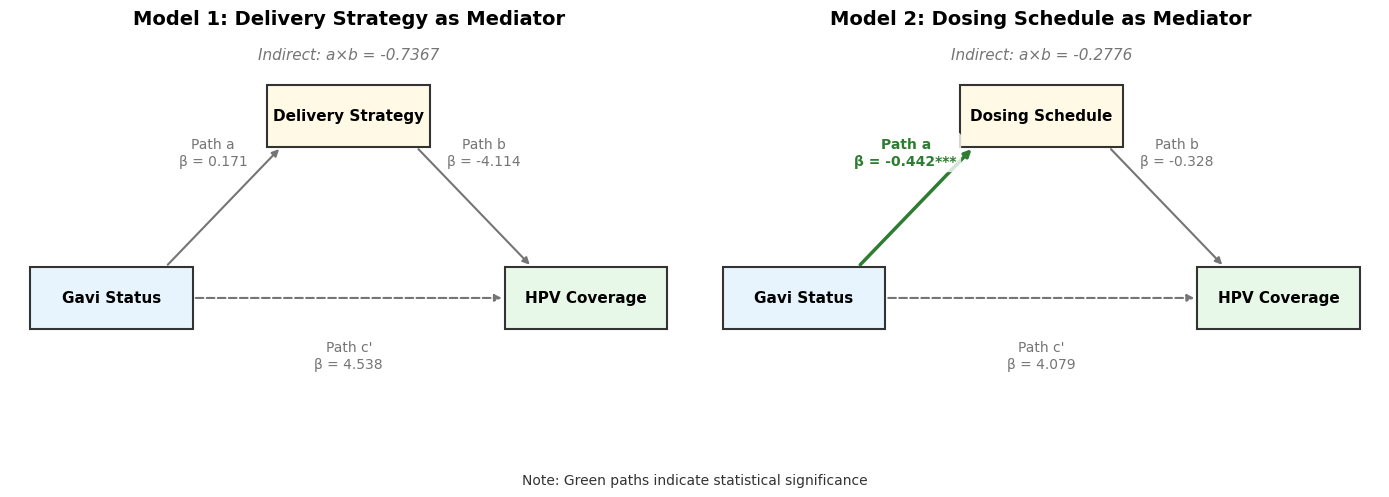

In [34]:
# Create figure
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

def fmt(coef, p):
    """Format coefficient with significance stars"""
    sig = '***' if p < 0.001 else '**' if p < 0.01 else '*' if p < 0.05 else ''
    color = '#2E7D32' if p < 0.05 else '#757575'
    weight = 'bold' if p < 0.05 else 'normal'
    lw = 2.5 if p < 0.05 else 1.5
    return f'β = {coef:.3f}{sig}', color, weight, lw

def draw_mediation_beta(ax, mediator, data):
    """Draw a single mediation diagram with beta coefficients"""
    ax.set_xlim(0, 10)
    ax.set_ylim(0, 8)
    ax.axis('off')
    
    # Node positions
    X, M, Y = (1.5, 3), (5, 6.5), (8.5, 3)
    
    # Draw nodes
    for pos, label, color in [(X, 'Gavi Status', '#E8F4FD'), 
                              (M, mediator, '#FFF9E6'), 
                              (Y, 'HPV Coverage', '#E8F8E8')]:
        ax.add_patch(plt.Rectangle((pos[0]-1.2, pos[1]-0.6), 2.4, 1.2,
                     facecolor=color, edgecolor='#333', linewidth=1.5, zorder=2))
        ax.text(pos[0], pos[1], label, ha='center', va='center',
                fontsize=11, fontweight='bold', zorder=3)
    
    # Draw path a: X → M
    a_txt, a_col, a_wt, a_lw = fmt(data['a_coef'], data['a_p'])
    ax.annotate('', xy=(M[0]-1, M[1]-0.6), xytext=(X[0]+0.8, X[1]+0.6),
                arrowprops=dict(arrowstyle='-|>', color=a_col, lw=a_lw))
    ax.text(3.0, 5.8, f'Path a\n{a_txt}', fontsize=10, color=a_col,
            fontweight=a_wt, ha='center', va='center', linespacing=1.3,
            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', edgecolor='none', alpha=0.8))
    
    # Draw path b: M → Y
    b_txt, b_col, b_wt, b_lw = fmt(data['b_coef'], data['b_p'])
    ax.annotate('', xy=(Y[0]-0.8, Y[1]+0.6), xytext=(M[0]+1, M[1]-0.6),
                arrowprops=dict(arrowstyle='-|>', color=b_col, lw=b_lw))
    ax.text(7.0, 5.8, f'Path b\n{b_txt}', fontsize=10, color=b_col,
            fontweight=b_wt, ha='center', va='center', linespacing=1.3,
            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', edgecolor='none', alpha=0.8))
    
    # Draw path c': X → Y (direct)
    c_txt, c_col, c_wt, c_lw = fmt(data['c_coef'], data['c_p'])
    ax.annotate('', xy=(Y[0]-1.2, Y[1]), xytext=(X[0]+1.2, X[1]),
                arrowprops=dict(arrowstyle='-|>', color=c_col, lw=c_lw, linestyle='--'))
    ax.text(5, 1.9, f"Path c'\n{c_txt}", fontsize=10, color=c_col,
            fontweight=c_wt, ha='center', va='center', linespacing=1.3,
            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', edgecolor='none', alpha=0.8))
    
    # Add indirect effect
    sig_ind = '***' if data['indirect_p'] < 0.001 else '**' if data['indirect_p'] < 0.01 else '*' if data['indirect_p'] < 0.05 else ''
    color_ind = '#2E7D32' if data['indirect_p'] < 0.05 else '#757575'
    ax.text(5, 7.6, f"Indirect: a×b = {data['indirect']:.4f}{sig_ind}",
            ha='center', fontsize=11, color=color_ind, style='italic',
            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', edgecolor='none', alpha=0.8))

# Draw both models
draw_mediation_beta(axes[0], 'Delivery Strategy', mediation_data['Delivery'])
axes[0].set_title('Model 1: Delivery Strategy as Mediator', fontsize=14, fontweight='bold', pad=10)

draw_mediation_beta(axes[1], 'Dosing Schedule', mediation_data['Dosing'])
axes[1].set_title('Model 2: Dosing Schedule as Mediator', fontsize=14, fontweight='bold', pad=10)

fig.text(0.5, 0.02,
         'Note: Green paths indicate statistical significance',
         ha='center', fontsize=10, color='#333')

plt.tight_layout(rect=[0, 0.05, 1, 1])
plt.show()